# Compare the tidal energy dissipation due to bottom drag (shelf) in the tide-only 1-layer global MOM6 

Dir: /g/data/nm03/lxy581/archive/tides_01_global_cdrag_const/

In [2]:
%matplotlib inline

import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

### MOM6: calculate the energy dissipation

In [3]:
def interp_u2h(var):
    ds_u = xr.Dataset(data_vars={'dissip': (('yh','xq'), var),
                                },
                      coords={'lon': (('yh', 'xq'), np.array(geolon_u)),
                              'lat': (('yh', 'xq'), np.array(geolat_u))})
    ds_h = xr.Dataset(data_vars={"lat": (('yh', 'xh'), np.array(geolat)),
                                 "lon": (('yh', 'xh'), np.array(geolon)),
                                 },
                      coords={"yh":yh, "xh":xh})
    regridder_u2h = xe.Regridder(ds_u, ds_h, "bilinear", extrap_method="inverse_dist")
    ds_h = regridder_u2h(ds_u)
    return ds_h['dissip']

In [4]:
def interp_v2h(var):
    ds_v = xr.Dataset(data_vars={'dissip': (('yq','xh'), var),
                                },
                      coords={'lon': (('yq', 'xh'), np.array(geolon_v)),
                              'lat': (('yq', 'xh'), np.array(geolat_v))})
    ds_h = xr.Dataset(data_vars={"lat": (('yh', 'xh'), np.array(geolat)),
                                 "lon": (('yh', 'xh'), np.array(geolon)),
                                 },
                      coords={"yh":yh, "xh":xh})
    regridder_v2h = xe.Regridder(ds_v, ds_h, "bilinear", extrap_method="inverse_dist")
    ds_h = regridder_v2h(ds_v)
    return ds_h['dissip']

In [5]:
def dissip_bottom_drag(cdrag,outdata,itime=np.arange(236)):
    
    data = xr.open_dataset(outdata)
    xh = np.array(data.xh)
    xq = np.array(data.xq)
    yq = np.array(data.yq)
    yh = np.array(data.yh)
    uo = np.squeeze(np.array(data['uo'].isel({'time':itime})))
    vo = np.squeeze(np.array(data['vo'].isel({'time':itime})))

    taux_bot = np.squeeze(np.array(data['taux_bot'].isel({'time':itime})))
    tauy_bot = np.squeeze(np.array(data['tauy_bot'].isel({'time':itime})))
    dissip_u = np.nanmean(taux_bot*uo, axis=0)
    dissip_v = np.nanmean(tauy_bot*vo, axis=0)
    dissip_u2h = interp_u2h(dissip_u)
    dissip_v2h = interp_v2h(dissip_v)
    dissip = dissip_u2h + dissip_v2h

    return dissip

In [6]:
file_out   = '/g/data/nm03/lxy581/archive/tides_01_global_cdrag_const/output002/ocean_interior.nc'
file_stats = '/g/data/nm03/lxy581/archive/tides_01_global_cdrag_const/output003/ocean_static.nc'
file_cdrag = '/g/data/nm03/lxy581/input/tides_01deg_drag_coeff/shelf_01deg_cd_const.nc'

In [7]:
fout  = xr.open_dataset(file_out)
stats = xr.open_dataset(file_stats)
cdrag = xr.open_dataset(file_cdrag)

In [8]:
cd = cdrag['cd_bot']
rho_0  = 1035.0
depth  = stats['deptho']
geolon = stats['geolon']
geolat = stats['geolat']
geolon_u = stats['geolon_u']
geolat_u = stats['geolat_u']
geolon_v = stats['geolon_v']
geolat_v = stats['geolat_v']
area   = stats['areacello']
yh, xh = stats.yh, stats.xh
fac_dep = xr.where(depth > 1000, 1, np.nan) 
fac_lat = xr.where((geolat < 75) & (geolat > -75), 1, np.nan)

In [9]:
topog = xr.open_dataset('/g/data/nm03/lxy581/input/tides_01deg_drag_coeff/ocean_topog.nc')
depth = topog.depth
depth_z = np.array(depth)
depth_z[depth_z==0]=np.nan
depth_da = xr.Dataset(data_vars={'depth_xr': (('yh','xh'), depth_z),
                                }, 
                      coords={'lon': (('yh', 'xh'), np.array(geolon)),
                              'lat': (('yh', 'xh'), np.array(geolat))})
land = xr.where(np.isnan(depth_da.depth_xr[:,:].rename('land')), 1, np.nan)

In [10]:
dissip_bot = dissip_bottom_drag(cd,file_out)

--------------------------------------------------------------------------

  Local host:   gadi-cpu-bdw-0510
  Local device: mlx5_0
--------------------------------------------------------------------------


In [11]:
global_bot = np.nansum(np.array(dissip_bot) * np.array(area)) / 1e+12

In [12]:
dissip = xr.Dataset(data_vars={'dissip_bot': (('yh','xh'), np.array(dissip_bot))}, 
                    coords={'lon': (('yh', 'xh'), np.array(geolon)),
                            'lat': (('yh', 'xh'), np.array(geolat))})

### Plot the snapshot of energy dissipation due to wave drag

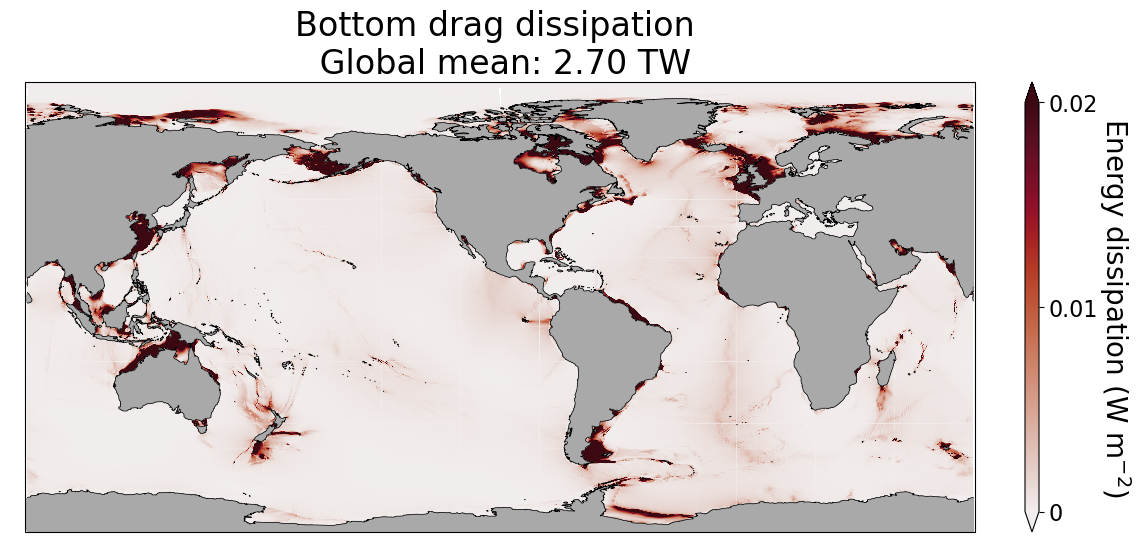

In [16]:
varlist = ['dissip_bot']
title   = ['Bottom drag dissipation \n Global mean: %.2f TW'%(global_bot)]

tick_locs = np.array([0,0.01,0.02])
tick_labels = np.array(["0","0.01","0.02"])

fig = plt.figure(figsize=(14, 6))
axs = []

gridsubs = gridspec.GridSpec(1,1)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

for I, (ax, var) in enumerate(zip(axs, varlist)):

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
    # Add model land mask
    land.plot.contourf(ax=ax, x='lon', y='lat', colors='darkgrey', zorder=2, add_colorbar=False)
    # Add model coastline
    land.fillna(0).plot.contour(ax=ax, x='lon', y='lat', colors='k', levels=[0, 1], add_colorbar=False, linewidths=0.5)

    p1 = ax.pcolormesh(geolon, geolat, globals()[var], cmap=cm.cm.amp, vmin=0, vmax=0.02)
    # p1 = ax.pcolormesh(geolon, geolat, globals()[var], transform=ccrs.PlateCarree(), cmap=cm.cm.deep, norm=LogNorm(vmin=1e-4, vmax=1e-2))
    plt.title(title[I],fontsize=24)
  
    ax.set_position([0.1,0.1,0.75,0.75])
    ax_cb = plt.axes([0.85, 0.1, 0.01, 0.75])
    
    cb1 = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel('Energy dissipation (W m$^{-2}$)',fontsize=20,rotation=270,labelpad=25);
    cb1.ax.tick_params(labelsize=16)
    cb1.locator   = matplotlib.ticker.FixedLocator(tick_locs)
    cb1.formatter = matplotlib.ticker.FixedFormatter(tick_labels)
        
plt.savefig('/g/data/nm03/lxy581/exps_figs/M2_dissip_01_shelf_drag_const.png', dpi=300, bbox_inches='tight')